In [26]:
!pip install pylate

# New Section

# **Import libraries**

In [27]:
import pandas as pd
import json
import re
#from bs4 import BeautifulSoup
import nltk
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from pylate import indexes, models, retrieve, rank

# **Load Collection to Index**

## Must be in 'tsv' file format where first column is docID/pid and second column is text

In [28]:
collection = pd.read_csv(r'combined_collection_titles.tsv', sep='\t', header=None, names=['docID', 'text', 'title'])
collection['text'] = collection['text'].fillna('')
collection['title'] = collection['title'].fillna('')

# **Load User Records and Split bold text**

# Split user's record into train (for profile generation) and test (records to test)

In [29]:
user_records = pd.read_csv('filtered_users_100_9.csv')
# Initialize empty dataframes for train and test
train_records = pd.DataFrame()
test_records = pd.DataFrame()

# For each user, split into train and test with a 70-30 ratio
for user_id, user_data in user_records.groupby('AnonID'):
    user_train = user_data.sample(frac=0.8, random_state=42)
    user_test = user_data.drop(user_train.index)

    train_records = pd.concat([train_records, user_train], ignore_index=True)
    test_records = pd.concat([test_records, user_test], ignore_index=True)

# Save train and test dataframes to CSV files
train_records.to_csv('train_records.csv', index=False)
test_records.to_csv('test_records.csv', index=False)

# **Filtering Docs to Index**

# Only 'test' records queries will be searched in the index, so only documents in CandiList of test records are added to the index

In [30]:
# Extract docIDs from test_records CandiList
test_docIDs = set()
for candi_list in test_records['CandiList']:
    # Parse the string into a list of docIDs
    doc_ids = [doc.strip().strip("'") for doc in candi_list.split(',')]
    test_docIDs.update(doc_ids)

#print("Length of test_docIDs: ", len(test_docIDs))

# Extract docIDs corresponding to ClickPos from train_records
train_docIDs = set()
for _, row in train_records.iterrows():
    candi_list = [doc.strip().strip("'") for doc in row['CandiList'].split(',')]
    click_pos = row['ClickPos']
    if 0 <= click_pos <= len(candi_list):  # Ensure ClickPos is valid
        train_docIDs.add(candi_list[click_pos])  # Zero-based index

#print("Length of train_docIDs: ", len(train_docIDs))

# Combine docIDs from test and train
all_docIDs = test_docIDs.union(train_docIDs)

# Filter collection.tsv
filtered_collection = collection[collection['docID'].isin(all_docIDs)]

# Save the filtered collection to a new file
filtered_collection.to_csv('filtered_collection.tsv', sep='\t', index=False, header=False)

#print(f"Filtered collection saved to 'filtered_collection.tsv'")

#print(len(all_docIDs))

# **Divide tsv file into separate lists for text and docIDs**

In [31]:
documents = filtered_collection['title'].tolist()#use document text content instead of document titles
#documents = filtered_collection['text'].tolist()#use document titles instead of document text content
documents_ids = filtered_collection['docID'].astype(str).tolist()
#print(len(documents))
#print(len(documents_ids))

# **Create Index (if not already created)**

# Pass text content and docIDs as parameters

In [32]:
model = models.ColBERT(
    model_name_or_path="lightonai/colbertv2.0",
)

index = indexes.Voyager(
    index_folder="pylate-index",
    index_name="index",
    override=True,
)


# Encode the documents
documents_embeddings = model.encode(
    documents,
    #batch_size=32,
    is_query=False, # Encoding documents
    show_progress_bar=True,
)

#Create a dictionary of doc ids to doc embeddings
id_to_embedding = dict(zip(documents_ids, documents_embeddings))

Encoding documents (bs=32):   0%|          | 0/26 [00:00<?, ?it/s]

In [33]:
# Convert the collection DataFrame to a dictionary for faster lookups
#CHANGE TO INCLUDE TEXT AND TITLE
doc_content_dict = filtered_collection.set_index('docID')['title'].to_dict()#use titles
#doc_content_dict = filtered_collection.set_index('docID')['text'].to_dict()#use texts

In [34]:
def preprocess_text(text):
    # Lowercase
    text = text.lower()

    # Remove boilerplate phrases (example)
    boilerplate_phrases = ["copyright", "all rights reserved", "terms of service"]
    for phrase in boilerplate_phrases:
        text = text.replace(phrase, "")

    # Remove special characters
    text = re.sub(r"[^a-zA-Z0-9\s]", " ", text)

    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()

    return text

# **Organizing Query Records for Profile and Testing**




*   For User Profile, need to obtain all clicked documents from train records against each User ID.
*   For testing, need to store the CandiList and ClickPos for each query.

* Clicked docIDs stored against each user in a dictionary bold text







In [35]:
# Extract list of clicked docs for each user
clicked_docs_by_user = {}
for _, row in train_records.iterrows():
    user_id = row['AnonID']
    candi_list = [doc.strip("' ") for doc in row['CandiList'].strip('[]').split(',')]
    click_pos = row['ClickPos']
    if 0 <= click_pos < len(candi_list):
        clicked_doc = candi_list[click_pos]
        if user_id not in clicked_docs_by_user:
            clicked_docs_by_user[user_id] = []
        clicked_docs_by_user[user_id].append(clicked_doc)

#print("Clicked docs by user:")
#print(clicked_docs_by_user)

# **All clicked documents concatenated into a single string for user profile**

In [36]:
user_profiles = {}

# Iterate through each user and their associated documents
for user, docs in clicked_docs_by_user.items():
    concatenated_string = ""
    for doc_name in docs:
        # Retrieve the content from the dictionary
        content = doc_content_dict.get(doc_name)
        if content:
            # content = preprocess_text(content)
            concatenated_string += content + " "  # Add a space between concatenated content
        else:
            print(f"Document {doc_name} not found in the collection.")

    # Remove trailing space and assign to the final output
    user_profiles[user] = concatenated_string.strip()

# Print the final output
#print(json.dumps(user_profiles, indent=2))

filename = "user_profiles.json"
with open(filename, 'w') as file:
  json.dump(user_profiles, file)


Document d-6699 not found in the collection.
Document d-5955 not found in the collection.
Document d-6699 not found in the collection.


# **User_queries = Queries to test bold text**





In [37]:
#extract query, docs and clicked position into a dictionary
#for each query, pass list of documents to rerank function

user_queries = {}

#for each user in test_records, extract each query and corresponding candilist, clickpos, and doccount

for _, row in test_records.iterrows():
    user_id = row["AnonID"]
    query = row["QueryIndex"]
    candilist = [c.strip().strip("'") for c in row["CandiList"].split(",")]
    clickpos = row["ClickPos"]
    docscount = row["DocsCount"]

    if user_id not in user_queries:
        user_queries[user_id] = {}

    user_queries[user_id][query] = {
        "CandiList": candilist,
        "ClickPos": clickpos,
        "DocsCount": docscount,
    }

#print(json.dumps(user_queries, indent=2))

filename = "user_queries.json"
with open(filename, 'w') as file:
  json.dump(user_queries, file)

# **Personalization - Chunking Queries**

In [38]:
nltk.download('punkt_tab')

# Function to split a string into chunks of 32 tokens
def chunk_user_profile(profile, chunk_size=32):
    tokens = word_tokenize(profile)  # Tokenize the string
    chunks = [" ".join(tokens[i:i + chunk_size]) for i in range(0, len(tokens), chunk_size)]
    return chunks

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# **Functions for Evaluation Metrics**

# Mean Reciprocal Rank

In [39]:
def calculate_mrr(query_results, user_queries, new_candidate_lists):
    reciprocal_ranks = []

    # Iterate through each user and query
    for user, queries in query_results.items():
        # Convert user key to integer
        user_id = int(user)

        for query, results in queries.items():
            # Extract the clicked document ID
            original_click_pos = user_queries[user_id][query]["ClickPos"] # Access with integer key
            original_candilist = user_queries[user_id][query]["CandiList"]

            clicked_doc_id = original_candilist[original_click_pos]

            new_candilist = new_candidate_lists[user][query]

            # Extract new candidate list and find the rank of the clicked document
            # new_candilist = [result["document_id"] for result in results]
            if clicked_doc_id and clicked_doc_id in new_candilist:
                rank = new_candilist.index(clicked_doc_id) + 1  # Rank is 1-based
                reciprocal_ranks.append(1 / rank)
            else:
                reciprocal_ranks.append(0)  # No relevant document found in new ranking

    # Calculate MRR
    mrr = sum(reciprocal_ranks) / len(reciprocal_ranks) if reciprocal_ranks else 0
    return mrr


# Click Position Changes

In [40]:
def evaluate_click_pos_changes(query_results, user_queries, new_candidate_lists):
    improved = 0
    worsened = 0
    unchanged = 0
    not_found = 0
    total_queries = 0
    user_click_pos = {}

    # Iterate through each user and query
    for user, queries in query_results.items():
        user_id = int(user)
        user_results = [0,0,0,0] #improved, worse, unchanged, not found
        for query, results in queries.items():
            total_queries += 1

            # Extract the original and new click positions
            original_click_pos = user_queries[user_id][query]["ClickPos"]
            original_candilist = user_queries[user_id][query]["CandiList"]

            clicked_doc_id = original_candilist[original_click_pos]
            candi_list_for_this_query = new_candidate_lists[user][query]
            # Determine the new click position
            if clicked_doc_id and clicked_doc_id in candi_list_for_this_query:
                new_click_pos = candi_list_for_this_query.index(clicked_doc_id)
            else:
                new_click_pos = -1  # Clicked document not found in the new ranking

            # Compare click positions
            if new_click_pos == -1:
              not_found +=1
              user_results[3] += 1
            elif new_click_pos < original_click_pos:
              improved += 1
              user_results[0] += 1
            elif new_click_pos > original_click_pos:
              worsened += 1
              user_results[1] += 1
            else:
              unchanged += 1
              user_results[2] += 1

        user_click_pos[user] = user_results
    #print("Total queries: ", total_queries)

    # Calculate percentages
    improved_percent = (improved / total_queries) * 100 if total_queries > 0 else 0
    worsened_percent = (worsened / total_queries) * 100 if total_queries > 0 else 0
    unchanged_percent = (unchanged / total_queries) * 100 if total_queries > 0 else 0
    not_found_percent = (not_found / total_queries) * 100 if total_queries > 0 else 0

    return {
        "total_queries": total_queries,
        "improved": improved,
        "improved_percent": improved_percent,
        "worsened": worsened,
        "worsened_percent": worsened_percent,
        "unchanged": unchanged,
        "unchanged_percent": unchanged_percent,
        "not_found": not_found,
        "not_found_percent": not_found_percent,
        "user_click_pos": user_click_pos
    }


# **Saving  user queries with improved clicked-on document ranks**

In [58]:
import json

def save_personalization_improvements(
    query_results,
    user_queries,
    new_candidate_lists,
    output_path="personalization_improvements_by_user.json",
    min_queries_per_user=None, #Change here to control minimum viewed improved quries per user
    max_users=None # Change here to control number of users to view
):
    """
    Finds users for whom personalization improves the rank of the clicked document.
    For each such user, saves at least two improved queries to a JSON file grouped by user_id.
    """
    improvements_by_user = {}

    for user, queries in query_results.items():
        user_id = int(user)
        improved_queries = []

        for query, results in queries.items():
            original_click_pos = user_queries[user_id][query]["ClickPos"]
            original_candilist = user_queries[user_id][query]["CandiList"]
            clicked_doc_id = original_candilist[original_click_pos]

            candi_list_for_this_query = new_candidate_lists[user][query]
            if clicked_doc_id and clicked_doc_id in candi_list_for_this_query:
                new_click_pos = candi_list_for_this_query.index(clicked_doc_id)
            else:
                new_click_pos = -1

            # Check for improvement
            if new_click_pos != -1 and new_click_pos < original_click_pos:
                improved_queries.append({
                    "query": query,
                    "clicked_doc_id": clicked_doc_id,
                    "original_rank": original_click_pos,
                    "new_rank": new_click_pos,
                    "improvement": original_click_pos - new_click_pos
                })

        if improved_queries:
          # Keep only users with >= min_queries_per_user improved queries
          # Sort by improvement (largest first)
          improved_queries = sorted(improved_queries, key=lambda x: x["improvement"], reverse=True)
          if min_queries_per_user and len(improved_queries) >= min_queries_per_user:
              improvements_by_user[user_id] = improved_queries[:min_queries_per_user]
          else:
            improvements_by_user[user_id] = improved_queries

        # Stop once we have enough users
        if max_users and len(improvements_by_user) >= max_users:
            break

    # Save to JSON
    with open(output_path, "w") as f:
        json.dump(improvements_by_user, f, indent=2)

    print(f"Saved personalization improvement examples for {len(improvements_by_user)} users to {output_path}")
    return improvements_by_user


# **Get User past queries**



In [59]:
user_query_history = train_records.groupby('AnonID')['QueryIndex'].apply(list)

**Defining profile weigths**

In [60]:
# Define weight ranges for queries and documents
weights = [(w, 1 - w) for w in [0.1 * i for i in range(11)]]  # (query_weight, doc_weight)
#weights = [(0.0, 1.0)] #We have chosen the best weight combination
#weights.append((1.0, 1.0))
print(f"Profile weights: {weights}")

Profile weights: [(0.0, 1.0), (0.1, 0.9), (0.2, 0.8), (0.30000000000000004, 0.7), (0.4, 0.6), (0.5, 0.5), (0.6000000000000001, 0.3999999999999999), (0.7000000000000001, 0.29999999999999993), (0.8, 0.19999999999999996), (0.9, 0.09999999999999998), (1.0, 0.0)]


# **Actual personalization computation**

In [61]:
# Store results for analysis
weight_results = []
best_doc_weight, best_query_weight, best_mrr, best_click_position_changes, best_query_results  = 0.0, 0.0, 0.0, None, None
# Iterate through each weight combination
for weight_query, weight_doc in weights:
    query_results = {}

    for user in user_queries:
        # Get user's past queries
        user_profile_queries = user_query_history.get(user, [])  # Get past queries for the user
        past_queries_text = " [Q] ".join(user_profile_queries)  # Concatenate with '[Q]' token

        # Get user's document content
        user_profile_docs = user_profiles[user]  # The document content for the profile

        # Chunk queries and docs separately
        query_chunks = chunk_user_profile(f"[Q] {past_queries_text}")
        doc_chunks = chunk_user_profile(f"[DOC] {user_profile_docs}")

        query_dict = user_queries[user]
        if user not in query_results:
            query_results[user] = {}

        for query in query_dict:
            candidate_docIDs = query_dict[query]['CandiList']

            # Initialize a list to store results for both query chunks and doc chunks
            query_chunk_results = []
            doc_chunk_results = []

            query_chunks_embeddings = model.encode(
                query_chunks,
                is_query=True,
            )

            doc_chunks_embeddings = model.encode(
                doc_chunks,
                is_query=True,
            )

            # Retrieve embeddings only for candidate IDs (if they exist in the mapping)
            filtered_candidate_docIDs = []
            filtered_candidate_doc_embeddings = []

            for doc_id in candidate_docIDs:
                if doc_id in id_to_embedding:
                    filtered_candidate_docIDs.append(doc_id)
                    filtered_candidate_doc_embeddings.append(id_to_embedding[doc_id])

            #candidate_doc_embeddings = [id_to_embedding[doc_id] for doc_id in candidate_docIDs if doc_id in id_to_embedding]
            '''
            print(f"candidate doc len: {len(candidate_docIDs)}")
            print(f"filtered candidate doc len: {len(filtered_candidate_docIDs)}")
            print(f"candidate doc embeddings  len: {len(candidate_doc_embeddings)}")
            print()
            '''
            # Search for each query chunk
            for chunk in query_chunks_embeddings:
                query_chunk_results.extend(rank.rerank(
                    documents_ids=[filtered_candidate_docIDs],
                    queries_embeddings=chunk,
                    documents_embeddings=[filtered_candidate_doc_embeddings]
                )[0])

            # Search for each document chunk
            for chunk in doc_chunks_embeddings:
                doc_chunk_results.extend(rank.rerank(
                    documents_ids=[filtered_candidate_docIDs],
                    queries_embeddings=chunk,
                    documents_embeddings=[filtered_candidate_doc_embeddings]
                )[0])
            '''
            print(f"Query chunk results: {query_chunk_results}")
            print(f"Doc chunk results: {doc_chunk_results}")
            print()
            '''

            # Aggregate results for query chunks
            query_max_score_dict = {}
            for result in query_chunk_results:
                doc_id = result["id"]
                score = result["score"]

                if doc_id not in query_max_score_dict:
                    query_max_score_dict[doc_id] = result
                else:
                    # Keep the entry with the higher score
                    if score > query_max_score_dict[doc_id]["score"]:
                        query_max_score_dict[doc_id] = result

            # Aggregate results for document chunks
            doc_max_score_dict = {}
            for result in doc_chunk_results:
                doc_id = result["id"]
                score = result["score"]

                if doc_id not in doc_max_score_dict:
                    doc_max_score_dict[doc_id] = result
                else:
                    # Keep the entry with the higher score
                    if score > doc_max_score_dict[doc_id]["score"]:
                        doc_max_score_dict[doc_id] = result

            # Combine query and doc chunk results with weights
            combined_score_dict = {}

            # Combine scores for each document
            for doc_id in set(query_max_score_dict.keys()).union(doc_max_score_dict.keys()):
                combined_score = 0.0
                if doc_id in query_max_score_dict:
                    combined_score += weight_query * query_max_score_dict[doc_id]["score"]
                if doc_id in doc_max_score_dict:
                    combined_score += weight_doc * doc_max_score_dict[doc_id]["score"]

                combined_score_dict[doc_id] = {
                    "id": doc_id,
                    "score": combined_score
                }

            # Convert combined scores to a list and sort by score descending
            aggregated_results = sorted(
                combined_score_dict.values(),
                key=lambda x: x["score"],
                reverse=True
            )

            # Store the final list
            query_results[user][query] = aggregated_results

    # Sort the documents in each query by their rank
    sorted_query_results = {
        user_id: {
            query: sorted(docs, key=lambda x: x['score'], reverse=True)
            for query, docs in queries.items()
        }
        for user_id, queries in query_results.items()
    }

    # Create new candidate lists
    new_candidate_lists = {
        user: {
            query: [result['id'] for result in results]
            for query, results in queries.items()
        }
        for user, queries in sorted_query_results.items()
    }

    # Calculate MRR and click position changes
    mrr = calculate_mrr(sorted_query_results, user_queries, new_candidate_lists)
    click_pos_changes = evaluate_click_pos_changes(sorted_query_results, user_queries, new_candidate_lists)

    if mrr > best_mrr:
        best_mrr = mrr
        best_doc_weight = weight_doc
        best_query_weight = weight_query
        best_click_position_changes = click_pos_changes
        best_query_results = sorted_query_results
    '''
    print(f"Query weight: {weight_query}")
    print(f"Doc weight: {weight_doc}")
    print(f"MRR: {mrr}")
    print(f"Click position changes: {click_pos_changes}")
    print()
    '''
    # Save results
    weight_results.append({
        "weight_query": weight_query,
        "weight_doc": weight_doc,
        "mrr": mrr,
        "click_pos_changes": click_pos_changes
    })

print("Best results: ")
print(f"Query weight: {weight_query}")
print(f"Doc weight: {best_doc_weight}")
print(f"MRR: {best_mrr}")
print(f"Click position changes: {best_click_position_changes}")
print(f"Best query results: {best_query_results}")
print()


Best results: 
Query weight: 1.0
Doc weight: 0.9
MRR: 0.5270068027210885
Click position changes: {'total_queries': 70, 'improved': 32, 'improved_percent': 45.714285714285715, 'worsened': 20, 'worsened_percent': 28.57142857142857, 'unchanged': 16, 'unchanged_percent': 22.857142857142858, 'not_found': 2, 'not_found_percent': 2.857142857142857, 'user_click_pos': {62917: [1, 1, 1, 0], 257689: [0, 1, 1, 0], 297468: [1, 0, 1, 0], 711391: [2, 1, 0, 0], 781341: [1, 1, 1, 0], 901695: [2, 0, 1, 0], 915996: [1, 1, 0, 1], 961732: [0, 1, 2, 0], 1117506: [1, 0, 1, 0], 1306380: [2, 0, 0, 0], 1424541: [2, 0, 1, 0], 1478898: [0, 0, 2, 0], 1510447: [1, 2, 0, 0], 1659408: [2, 1, 0, 0], 1702234: [2, 0, 0, 0], 1801284: [2, 1, 0, 0], 2226889: [1, 2, 0, 0], 2402080: [2, 0, 1, 0], 2439668: [2, 0, 1, 0], 2528943: [0, 2, 1, 0], 2752882: [1, 0, 0, 0], 3014747: [0, 3, 0, 0], 3097286: [0, 2, 1, 0], 3223920: [1, 0, 0, 0], 3327666: [1, 1, 0, 0], 3405054: [1, 0, 1, 0], 3483185: [1, 0, 0, 1], 3610850: [2, 0, 0, 0]}}
B

In [62]:
#Find queries for which rank of clicked on document improves
improved_results = save_personalization_improvements(
    query_results=best_query_results,
    user_queries=user_queries,
    new_candidate_lists=new_candidate_lists
)
#print(f"Improved results: {improved_results}")

Saved personalization improvement examples for 15 users to personalization_improvements_by_user.json


# **View users and queries with improved rank of clicked on document**

In [63]:

for user, queries in improved_results.items():
  print(f"Improved queries for user {user}: ")
  for i, query in enumerate(queries):
    print(f"({i+1}) {query}")
  print()


Improved queries for user 297468: 
(1) {'query': 'cspan.org', 'clicked_doc_id': 'd-60343', 'original_rank': 6, 'new_rank': 4, 'improvement': 2}
(2) {'query': 'feedblitz', 'clicked_doc_id': 'd-124595', 'original_rank': 1, 'new_rank': 0, 'improvement': 1}

Improved queries for user 711391: 
(1) {'query': 'i love alaska', 'clicked_doc_id': 'd-226169', 'original_rank': 5, 'new_rank': 0, 'improvement': 5}
(2) {'query': 'yahoo entertainment news', 'clicked_doc_id': 'd-5509', 'original_rank': 5, 'new_rank': 3, 'improvement': 2}

Improved queries for user 781341: 
(1) {'query': 'the ultimate wine cradle', 'clicked_doc_id': 'd-240972', 'original_rank': 5, 'new_rank': 4, 'improvement': 1}

Improved queries for user 901695: 
(1) {'query': 'nintendo gamecube games', 'clicked_doc_id': 'd-2148', 'original_rank': 5, 'new_rank': 0, 'improvement': 5}
(2) {'query': 'art center for kids', 'clicked_doc_id': 'd-264678', 'original_rank': 5, 'new_rank': 4, 'improvement': 1}

Improved queries for user 915996:

#**Plot results**


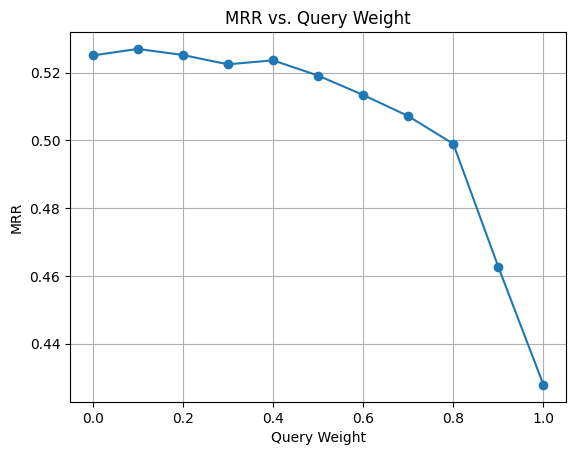

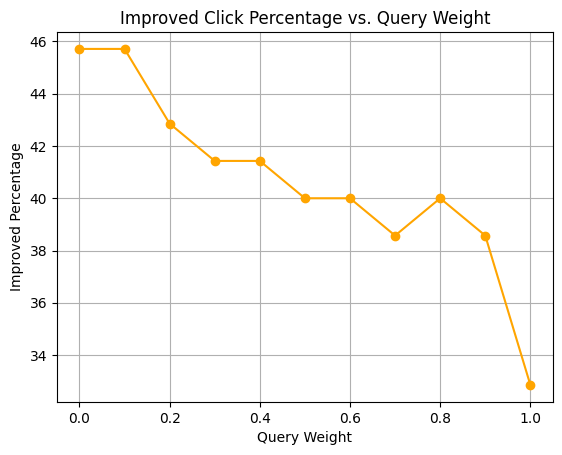

In [64]:
# Plot the results
mrr_values = [res["mrr"] for res in weight_results]
query_weights = [res["weight_query"] for res in weight_results]
improved_percentages = [res["click_pos_changes"]["improved_percent"] for res in weight_results]

# Plot MRR vs. query weight
plt.figure()
plt.plot(query_weights, mrr_values, marker='o')
plt.title("MRR vs. Query Weight")
plt.xlabel("Query Weight")
plt.ylabel("MRR")
plt.grid(True)
plt.show()
# Plot Improved Click Percentage vs. Query Weight
plt.figure()
plt.plot(query_weights, improved_percentages, marker='o', color='orange')
plt.title("Improved Click Percentage vs. Query Weight")
plt.xlabel("Query Weight")
plt.ylabel("Improved Percentage")
plt.grid(True)
plt.show()